### save it as html before submitting

In [4]:

import sqlite3
import os
import pandas as pd
import operator

# change to the directory where the files are stored
os.chdir("/Users/christopherpang/Desktop/Main/SIM uni year 2/Programming for data science/Coursework_data/dataverse_files")

try:
    os.remove('airline2.db')
except OSError:
    pass



# ======= create database =======
conn = sqlite3.connect('airline2.db')
#v1
#data1999= pd.read_csv("1999.csv")
#data2000= pd.read_csv("2000.csv")

#ontime_df = pd.concat([data1999,data2000], ignore_index=True, sort=False)


#v2
data_frames = []

# Loop through the years from 1991 to 2000
for year in range(1991, 2001):
    # Construct the file path for the CSV file
    file_path = f"{year}.csv"
    
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Append the DataFrame to the list
    data_frames.append(data)

    
    
# adding all DataFrames in the list into a single DataFrame
ontime_df = pd.concat(data_frames, ignore_index=True, sort=False)
airports_df = pd.read_csv("airports.csv")
carriers_df = pd.read_csv("carriers.csv")
planes_df = pd.read_csv("plane-data.csv")
#print(ontime_df.head)


# ======= statistics summary =======
summaryAirports = airports_df.describe(include='all')
#print(summaryAirports)

summaryCarriers = carriers_df.describe(include='all')
#print(summaryCarriers)

summaryPlanes = planes_df.describe(include='all')
#print(summaryPlanes)

summaryOntime = ontime_df.describe(include='all')
#print(summaryOntime)

c = conn.cursor()
c.execute('''
CREATE TABLE ontime (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')
conn.commit()




for year in range(1991, 2000):
    ontime = pd.read_csv(str(year)+".csv")
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)

conn.commit()



# ======= creating planData Table =======
conn = sqlite3.connect('airline2.db')
c = conn.cursor()
c.execute("DROP TABLE IF EXISTS planData")

c.execute('''CREATE TABLE planeData (
  Tailnum varchar(6),
  Type varchar(25),
  Manufacturer varchar(25),
  Issue_date varchar(10),
  Model varchar(10),
  Status varchar(5),
  Aircraft_type varchar(25),
  Engine_type varchar(25),
  Year int 
      
)
''')


conn.commit()

# ======= getting the issue date of the planes that have less delays =======
planes_df.to_sql('planeData', con = conn, if_exists = 'append', index = False)

conn.commit()

planeNum=c.execute(''' SELECT Issue_date FROM planeData JOIN ontime ON planeData.Tailnum= ontime.Tailnum WHERE ArrDelay < '5' AND DepDelay < '5'
''').fetchall()

column_name1=["IssueDate"]
issueDatePd= pd.DataFrame(planeNum, columns= column_name1)


# ======= getting the deptime for flights that delay more than 15 mins  =======
timeOfDay= c.execute(''' SELECT DepTime AS DepTime FROM ontime 
                         WHERE ArrDelay > '15' AND DepDelay > '15' 
    
''').fetchall()

column_name=["DepTime"]
timeOfDayPd=pd.DataFrame(timeOfDay, columns= column_name)

# ======= Answering Q1 best time of the week to fly   =======
timeOfDayPd['DepTime'] = timeOfDayPd['DepTime'].astype(str).str.zfill(4)
print(timeOfDayPd)
type(timeOfDayPd)

earlyMornCount=0  
midMornCount=0
lateMornCount=0
earlyAftCount=0
midAftCount=0
lateAftCount= 0
earlyEveCount=0
midEveCount=0
lateEveCount=0 
earlyOverCount=0
midOverCount=0
lateOverCount=0

for index, i in timeOfDayPd.iterrows():  
    #print(int(i['DepTime']))
    
    if 600<= int(i['DepTime']) <=800:
        
        earlyMornCount+=1
        #print(type(i['DepTime']))
            #print({'col1':i['DepTime']})
            
    elif 800<= int(i['DepTime']) <= 1000:   
        midMornCount+=1
        
    elif 1000<= int(i['DepTime']) <= 1200:   
        lateMornCount+=1
        
    elif 1200 <= int(i['DepTime']) <= 1400:
        earlyAftCount+=1
       #print(timeOfDayPdMorn)    
    
    elif 1400 <= int(i['DepTime']) <= 1600:
        midAftCount+=1
        
    elif  1600 <= int(i['DepTime']) <= 1800:
          lateAftCount+=1
            
    elif  1800 <= int(i['DepTime']) <= 2000:
         earlyEveCount+=1
        
    elif  2000 <= int(i['DepTime']) <= 2200:   
        midEveCount+=1
        
    elif  2200 <= int(i['DepTime']) <= 2359:     
        lateEveCount+=1
        
    elif  1 <= int(i['DepTime']) <= 200: 
        earlyOverCount+=1
        
    elif  200 <= int(i['DepTime']) <= 400: 
        midOverCount+=1
        
    elif  400 <= int(i['DepTime']) <= 600: 
        lateOverCount+=1
        
print( earlyMornCount) 
print( midMornCount)
print(lateMornCount)
print(earlyAftCount)
print(midAftCount)
print(lateAftCount)
print(earlyEveCount)
print(midEveCount)
print(lateEveCount)
print( earlyOverCount)
print(midOverCount)

print("Best time of the day to fly is early morning from 0600 to 0800")

#timeOfDayPdMorn2=pd.DataFrame(timeOfDayPdMorn, columns= column_name)
#print(len(timeOfDayPdMorn2))    
#print(timeOfDayPdMorn2)

    
        
       
   
    







         DepTime
0           1709
1           1704
2           1705
3           1709
4           1703
...          ...
36269428    1910
36269429    1909
36269430    1907
36269431    1907
36269432    1905

[36269433 rows x 1 columns]
5391485
5200765
4487369
4855375
4225677
4373622
3883089
2676284
681596
206813
20049
Best time of the day to fly is early morning from 0600 to 0800


### Best time of the day to fly for 10 years avg (havent do)

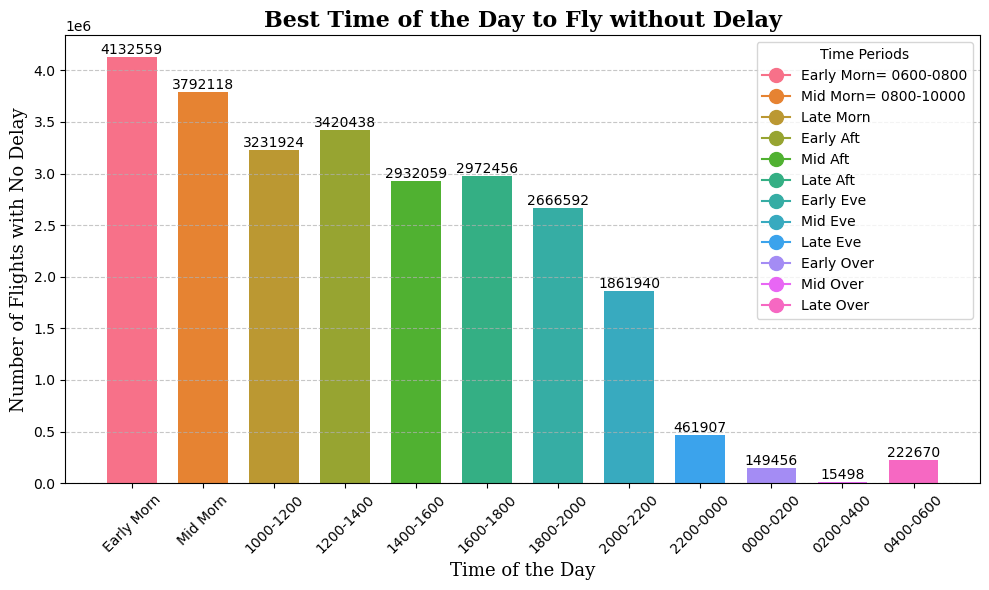

In [198]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# For y Aaxis
flight_counts = [earlyMornCount, midMornCount, lateMornCount, earlyAftCount, midAftCount, lateAftCount, earlyEveCount, 
                 midEveCount, lateEveCount, earlyOverCount, midOverCount, lateOverCount]

# Time intervals for x-axis
time_intervals = ['Early Morn', 'Mid Morn', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', 
                  '2000-2200', '2200-0000', '0000-0200', '0200-0400', '0400-0600']

# Set color 
colors = sns.color_palette("husl", len(time_intervals))

# Plot graph
plt.figure(figsize=(10, 6))
bars = plt.bar(time_intervals, flight_counts, color=colors, width=0.7)

# Add data labels on top of each bar
for i, count in enumerate(flight_counts):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

# Rotate x axis
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Time of the Day', fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Number of Flights with No Delay',fontdict={'fontsize': 13, 'family': 'serif'})
plt.title('Best Time of the Day to Fly without Delay', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})

# Add legend with custom labels
legend_labels = ['Early Morn= 0600-0800', 'Mid Morn= 0800-10000', 'Late Morn', 'Early Aft', 'Mid Aft', 'Late Aft',
                 'Early Eve', 'Mid Eve', 'Late Eve', 'Early Over', 'Mid Over', 'Late Over']
legend_elements = [Line2D([0], [0], color=colors[i], marker='o', markerfacecolor=colors[i], markersize=10, label=label) 
                   for i, label in enumerate(legend_labels)]

plt.legend(handles=legend_elements, loc='upper right', title='Time Periods')

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()








## Answering Q2a) Best time of the day to fly for 1991 to 1999 (plotting delays)

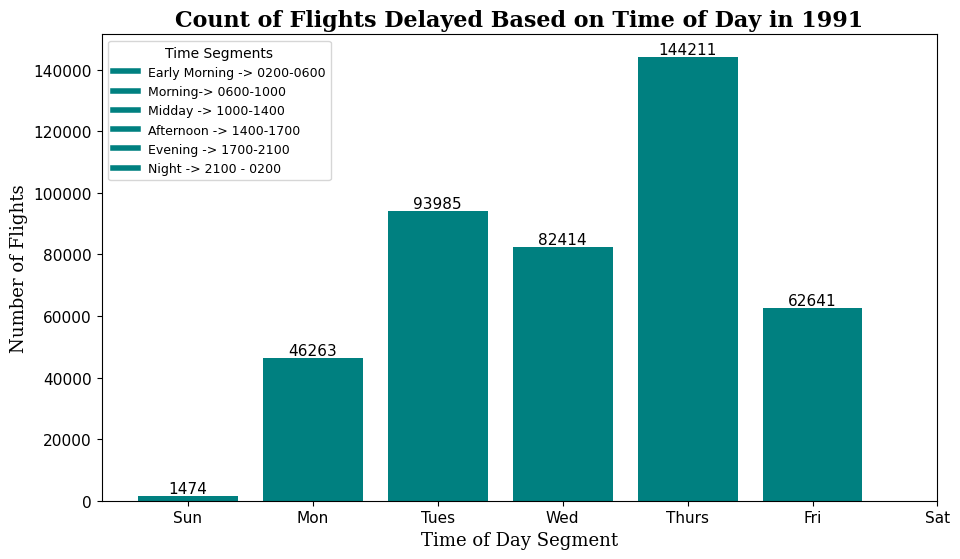

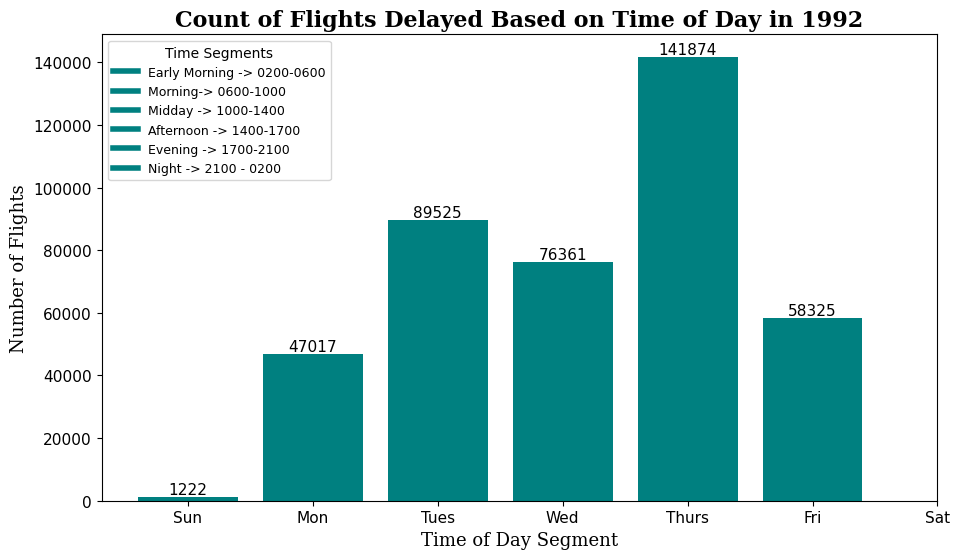

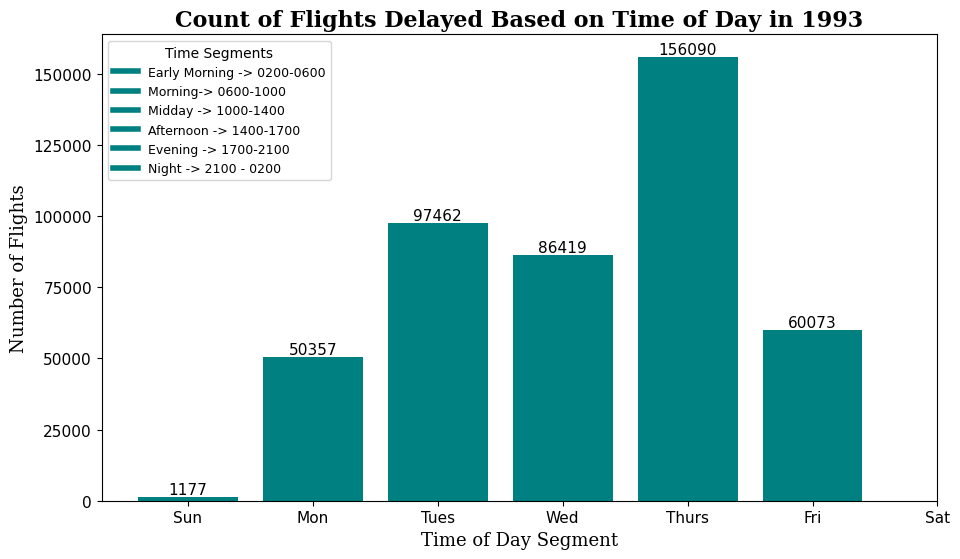

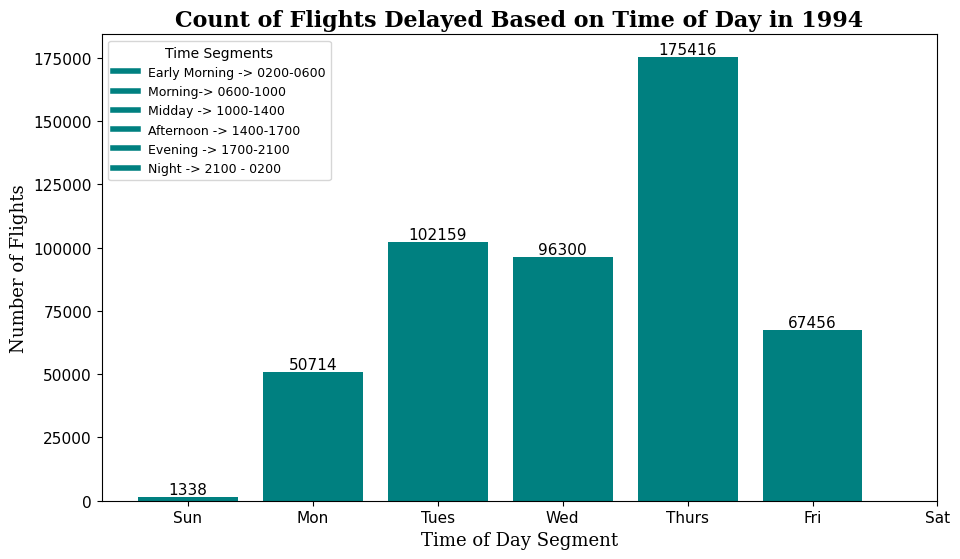

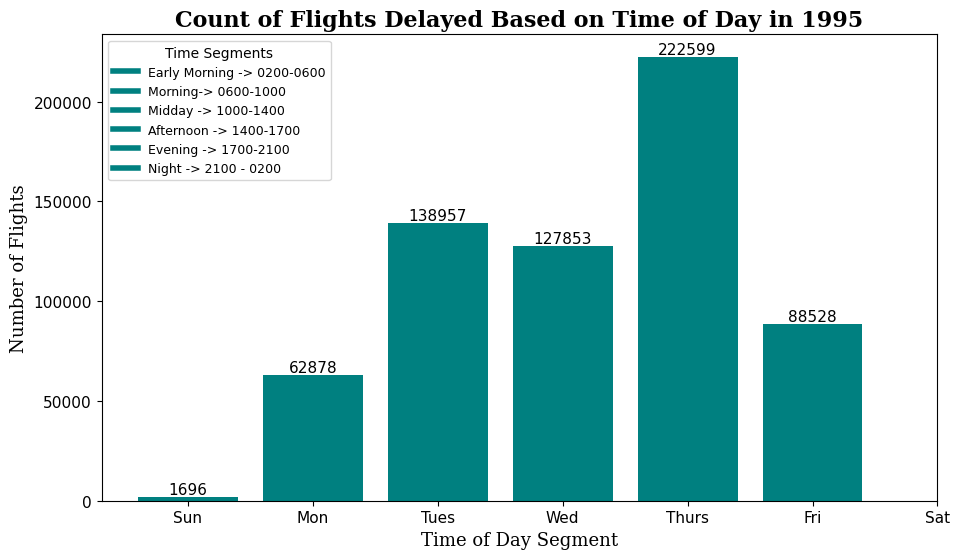

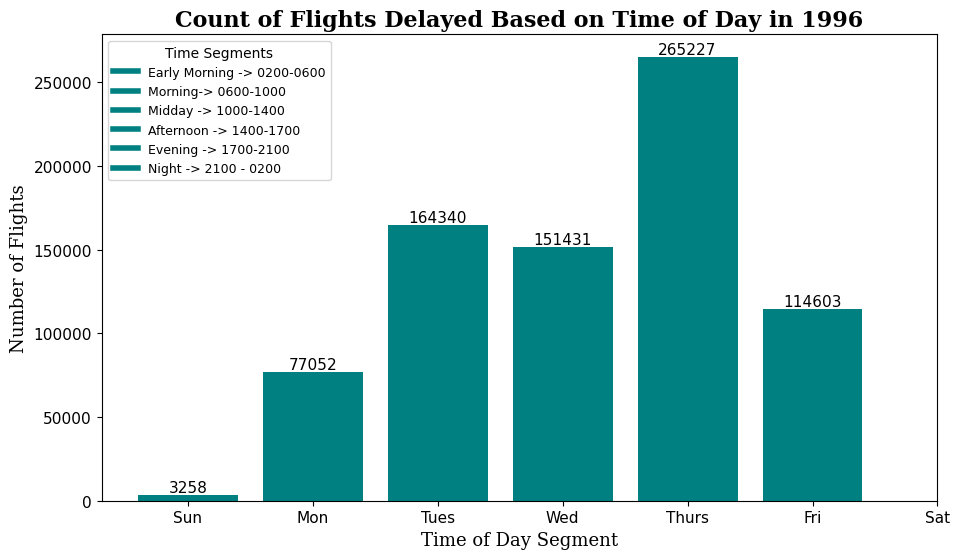

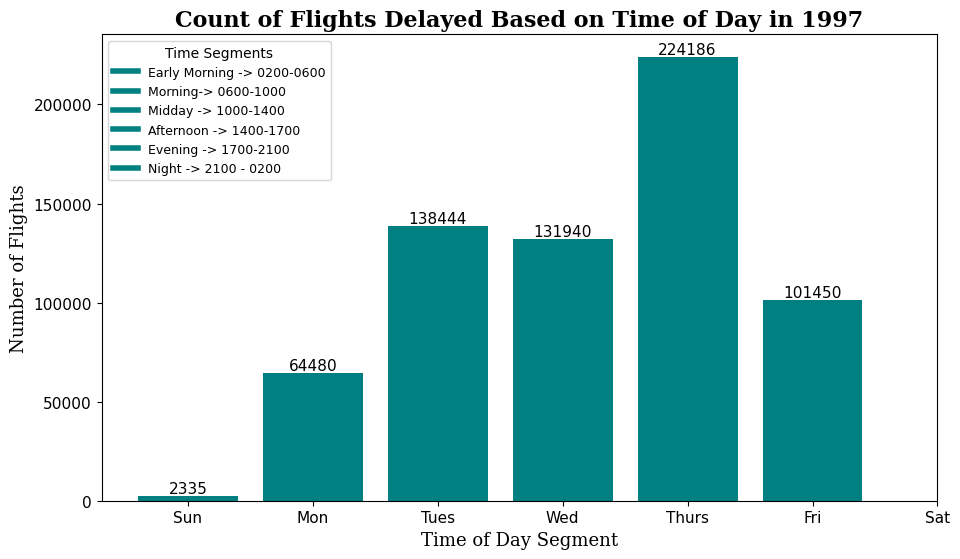

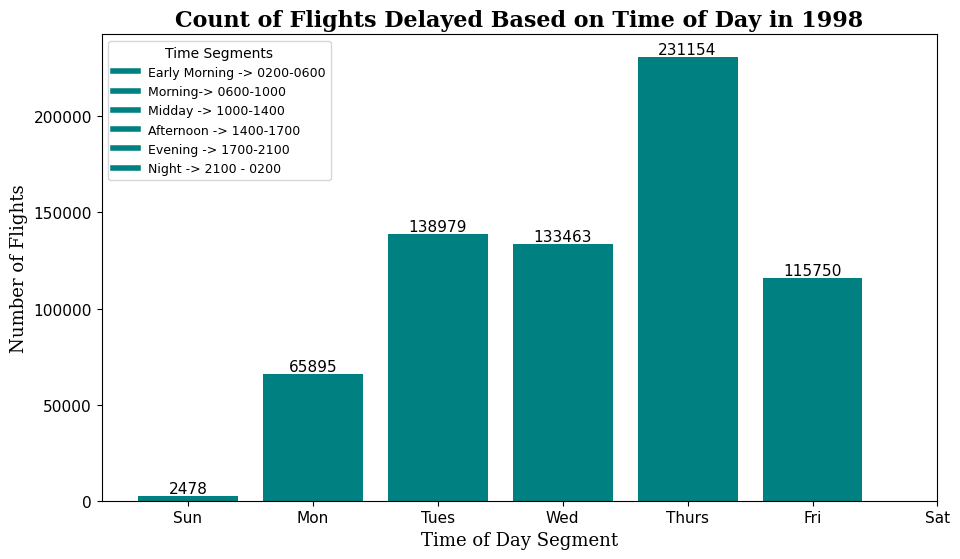

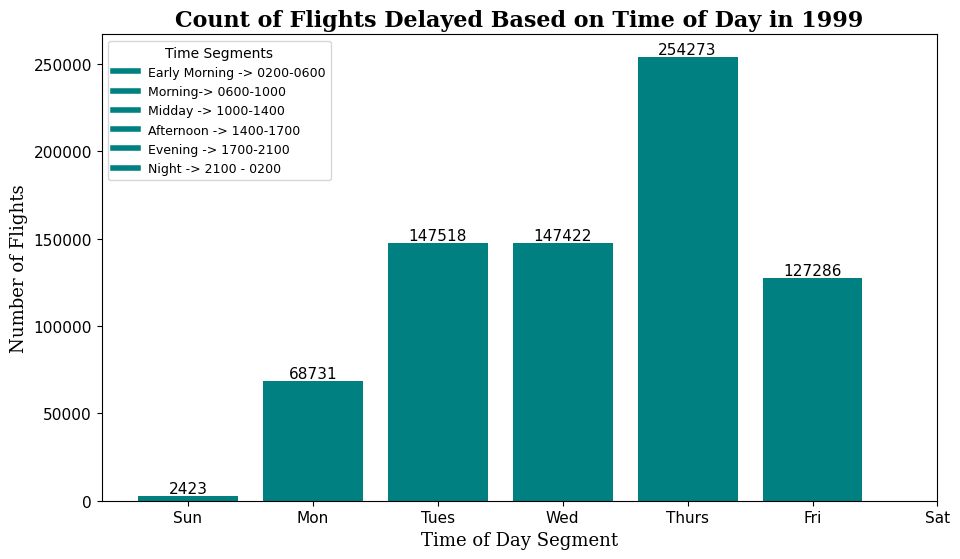

In [137]:
# Initialize a dictionary to store each year's lowest delay count and corresponding segments
lowest_delay_counts_by_year = {}

for year in range(1991, 2000):
    query = f"""
    SELECT CAST(DepTime AS INTEGER) AS DepTime FROM ontime
    WHERE ArrDelay > 15 AND DepDelay > 15 AND Year = {year}
    """
    timeOfDayPd = pd.read_sql_query(query, conn)
    timeOfDayPd['DepTime'] = timeOfDayPd['DepTime'].apply(lambda x: f"{x:04d}")
    timeOfDayPd['Segment'] = timeOfDayPd['DepTime'].apply(time_segment)

    segment_order = ['Early Morning', 'Morning', 'Midday', 'Afternoon', 'Evening', 'Night']
    timeOfDayPd['Segment'] = pd.Categorical(timeOfDayPd['Segment'], categories=segment_order, ordered=True)
    segment_counts_ordered = timeOfDayPd.groupby('Segment').size()

    # Find the lowest delay count for time of the day for the year and store it
    min_delay_count = segment_counts_ordered.min()
    lowest_delay_segments = segment_counts_ordered.idxmin()  # Get the segment name with the lowest count
    lowest_delay_counts_by_year[year] = {'count': min_delay_count, 'segment': lowest_delay_segments}
    
     
    
    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(segment_counts_ordered.index, segment_counts_ordered.values, color='teal')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, int(yval), ha='center', va='bottom',fontsize= '11' )

        
    # Adjust the size of the numbers on the axes
    plt.xticks(range(len(tick_label)), tick_label, fontsize=11)  
    plt.yticks(fontsize=11)    
        
    plt.legend(handles=legend_elements, title="Time Segments", title_fontsize='10', loc='upper left', fontsize='9', handlelength=2)
    plt.title(f'Count of Flights Delayed Based on Time of Day in {year}', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
    plt.xlabel('Time of Day Segment', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.ylabel('Number of Flights', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.xticks(rotation=360)  # Adjusted for better legibility
    plt.tight_layout()
    plt.show()



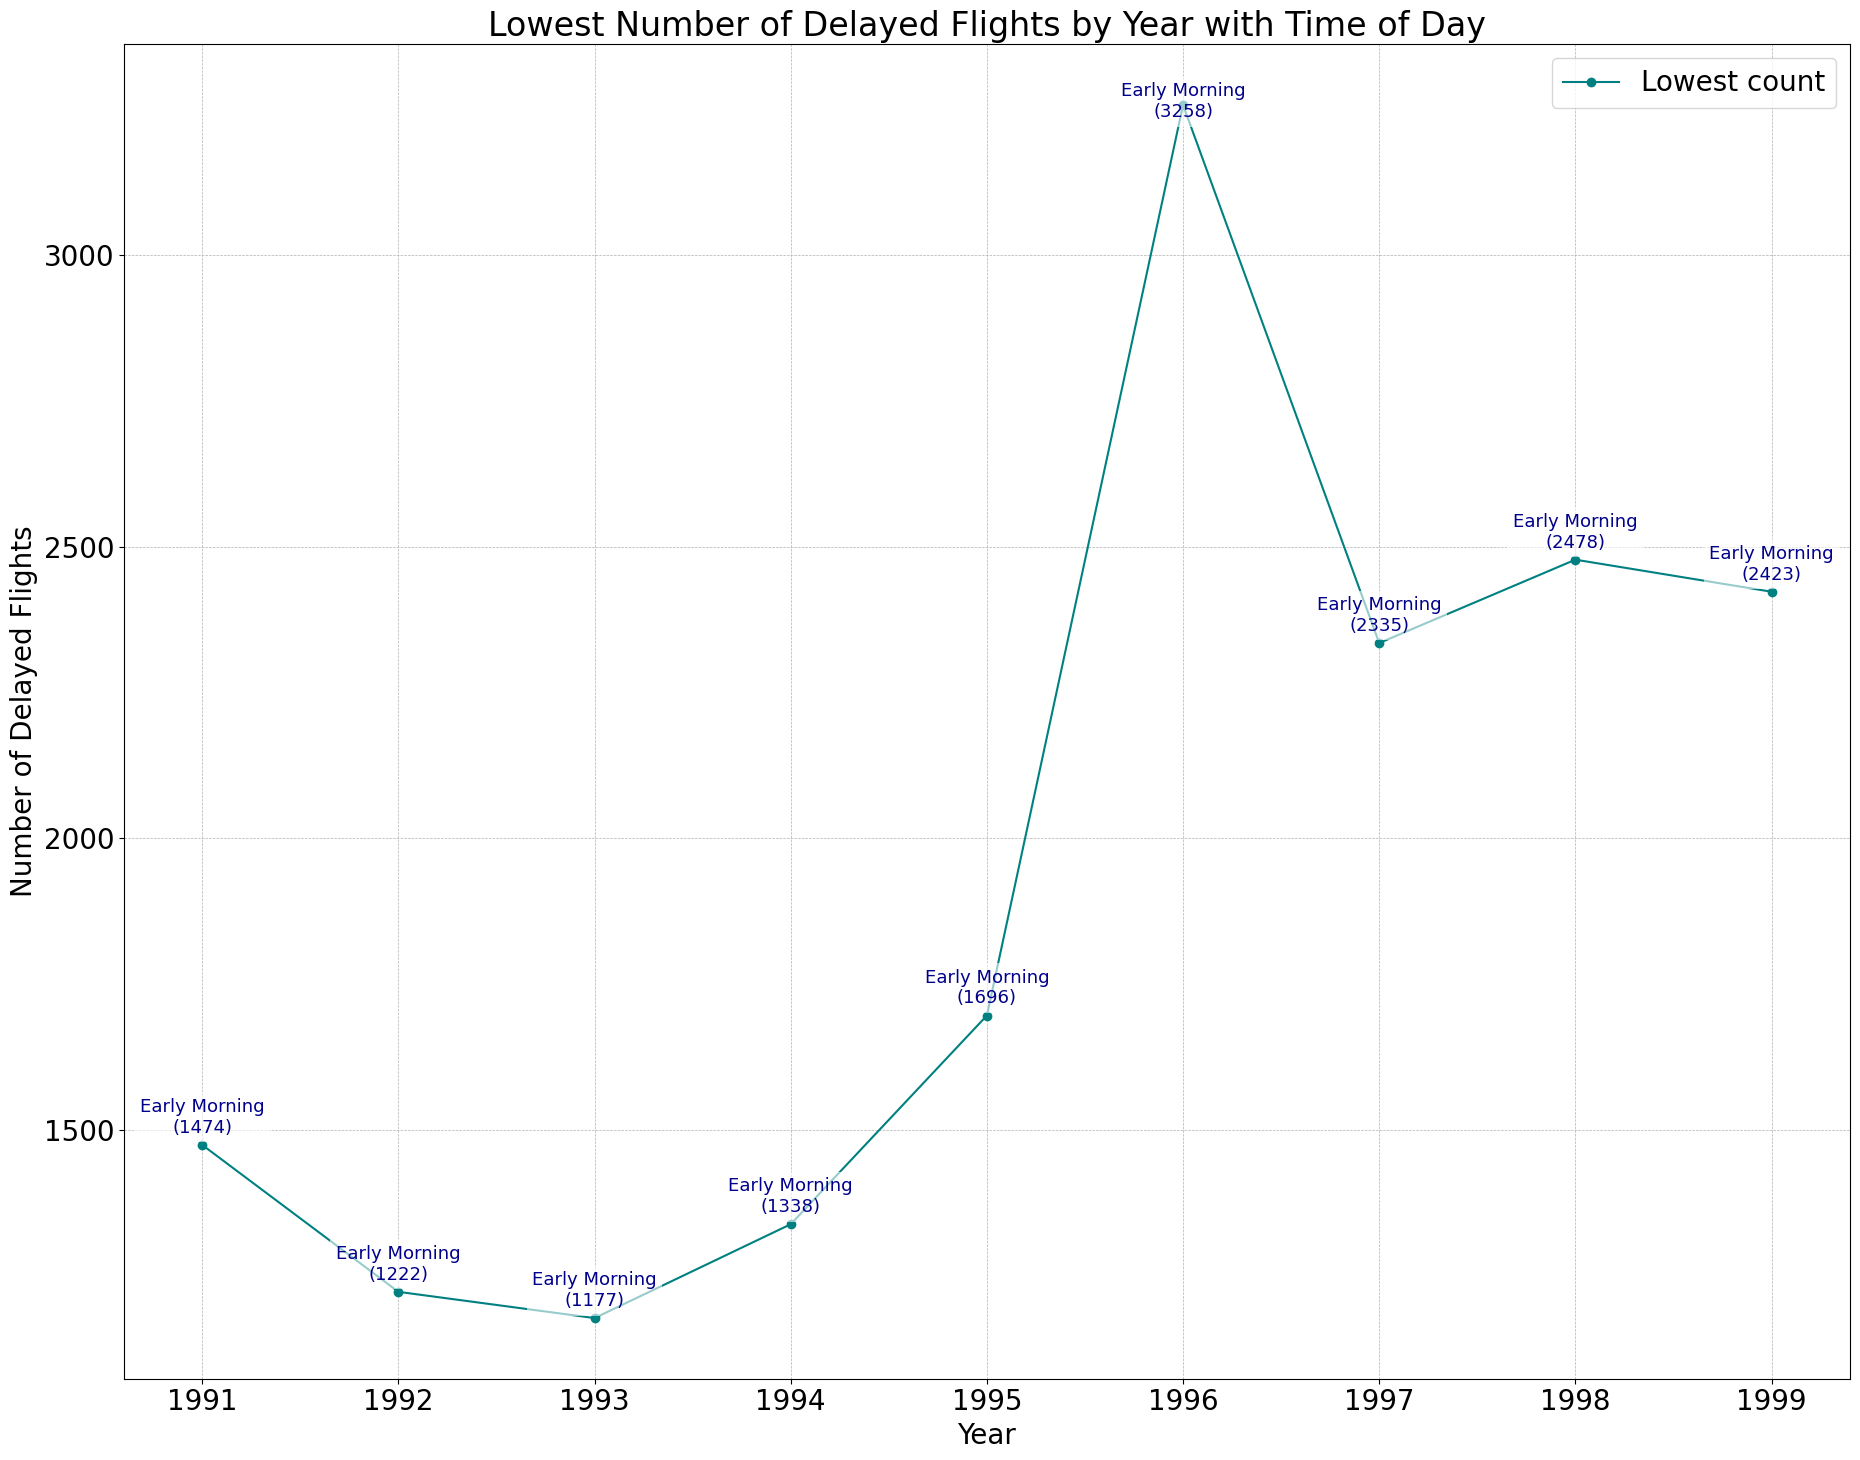

In [164]:


years = list(lowest_delay_counts_by_year.keys())
lowest_counts = [info['count'] for info in lowest_delay_counts_by_year.values()]
segments = [info['segment'] for info in lowest_delay_counts_by_year.values()]

#plt.rcParams.update({'font.size': 20})  # Adjusting for overall readability

plt.figure(figsize=(19, 15))
plt.plot(years, lowest_counts, marker='o', linestyle='-', color='teal', label='Lowest count')

# Determine the range of y-values to dynamically position text within the graph
y_min, y_max = min(lowest_counts), max(lowest_counts)
y_range = y_max - y_min
offset = y_range * 0.01  # Offset for text positioning, 5% of the y-range

# Plot adjustments to ensure text visibility and positioning within the graph
for i, (year, count, segment) in enumerate(zip(years, lowest_counts, segments)):
    # Calculate dynamic vertical position based on count value
    if count > y_max - offset:
        vertical_position = count - offset  # Move text down if too high
    else:
        vertical_position = count + offset  # Default: slightly above the point
    
    # Add the annotation with a consistent dark blue color and a white background box for visibility
    plt.text(year, vertical_position, f"{segment}\n({count})", 
             fontsize=13, ha='center',
             color='darkblue', bbox=dict( facecolor='white', alpha=0.6, edgecolor='none'))


    
plt.title('Lowest Number of Delayed Flights by Year with Time of Day')
plt.xlabel('Year')
plt.ylabel('Number of Delayed Flights')
plt.xticks(years)
plt.yticks()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

## Answering Q2a) best day of the week to fly to minimize delays 

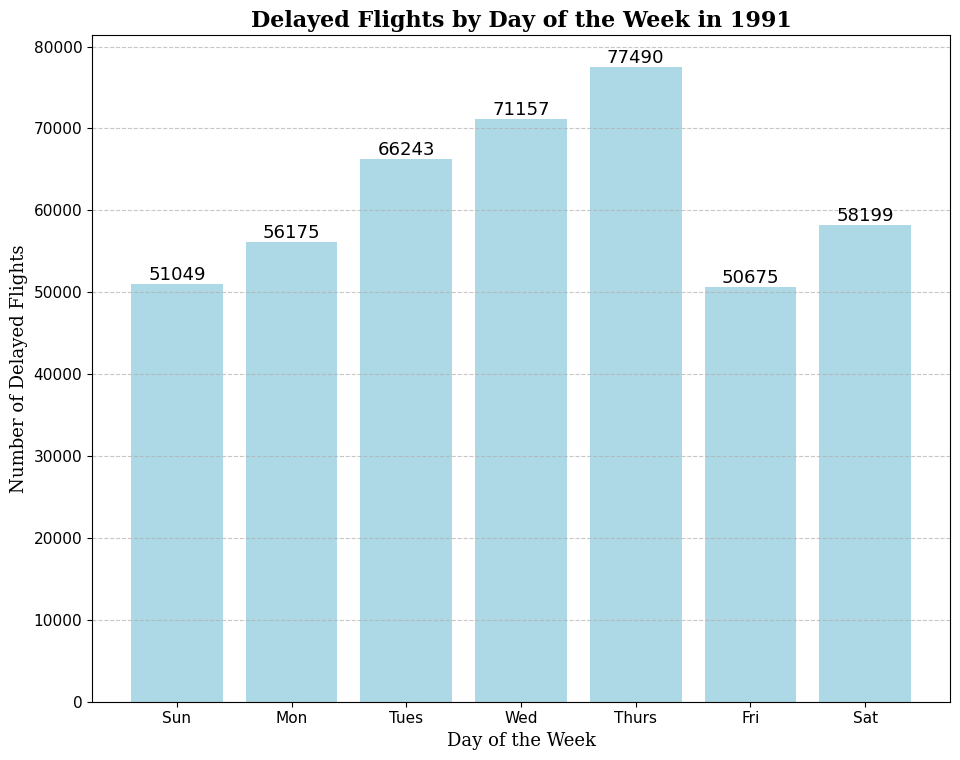

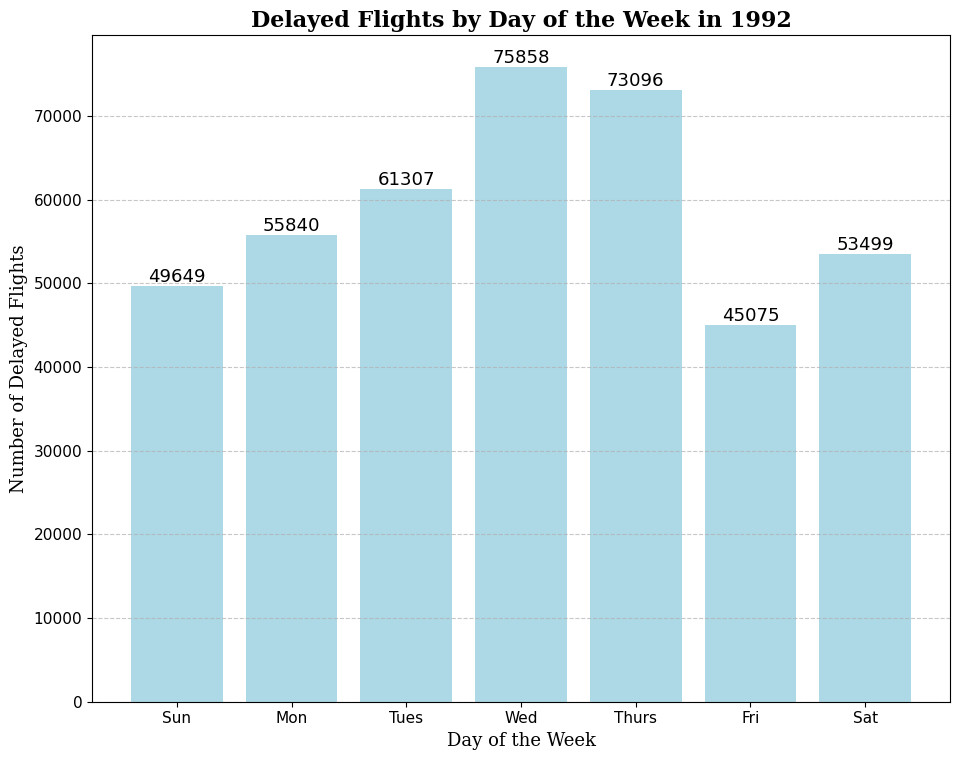

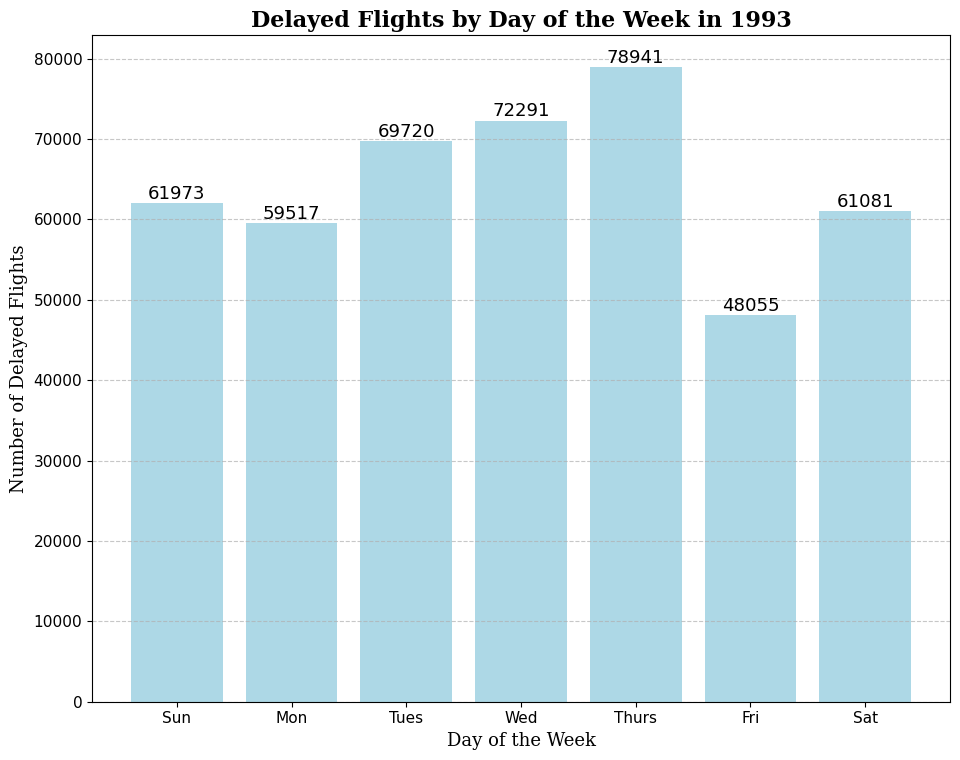

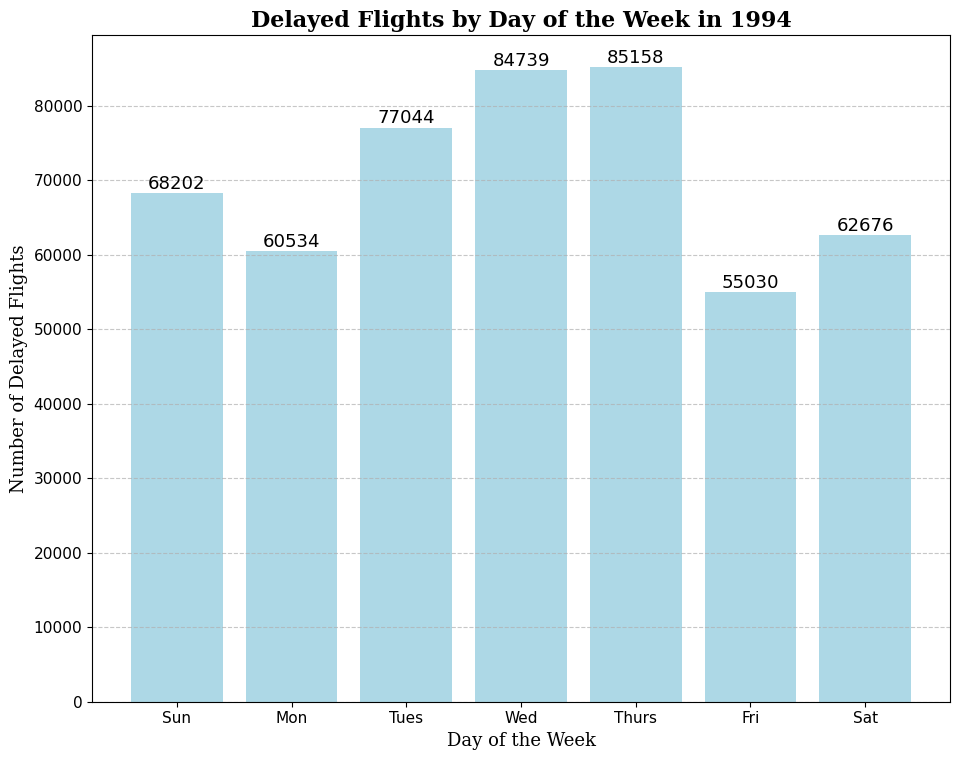

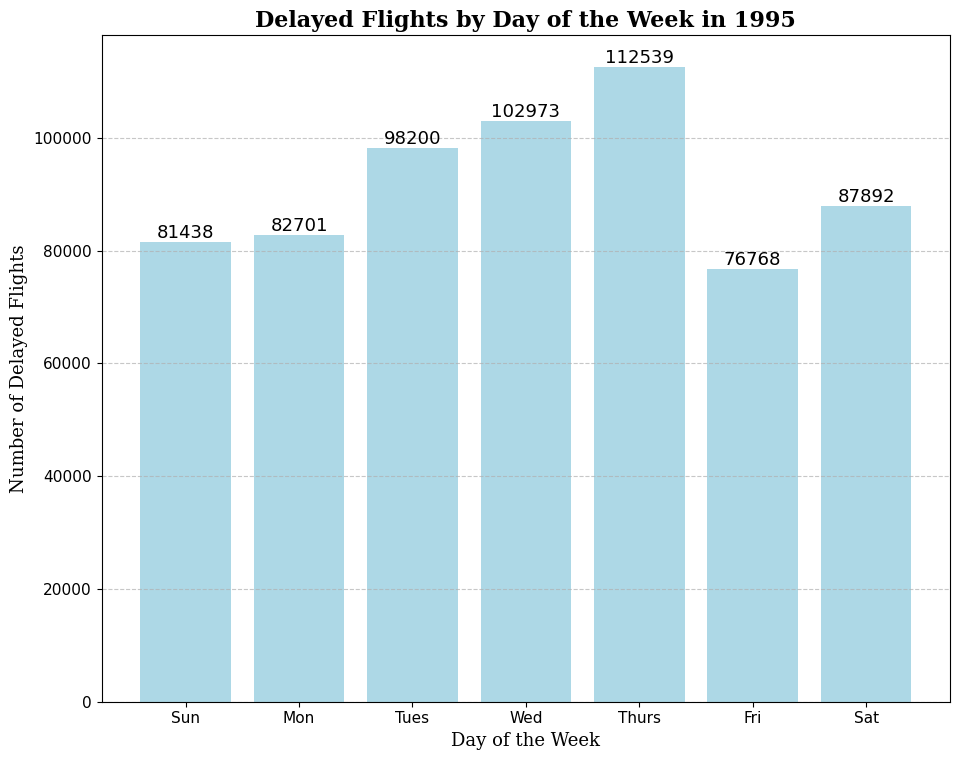

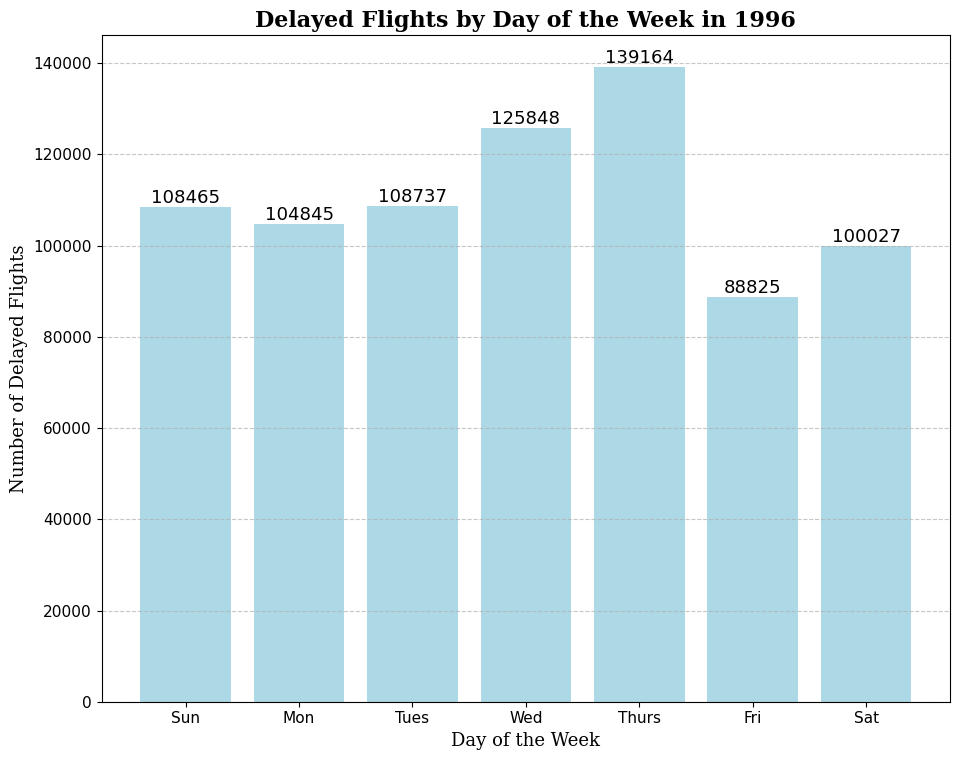

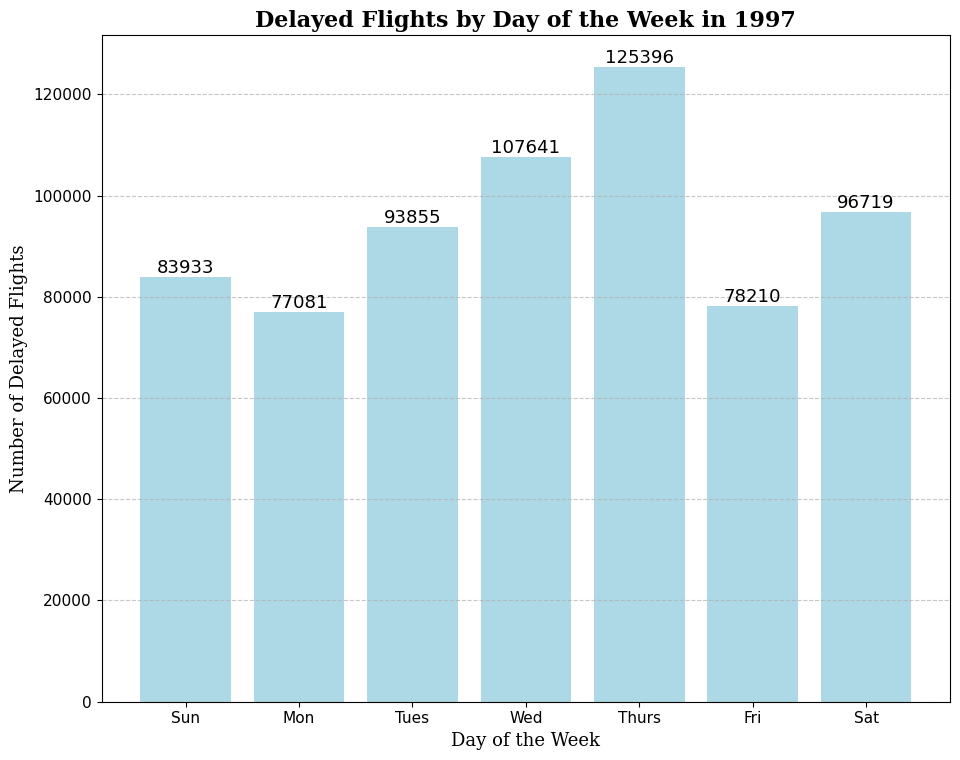

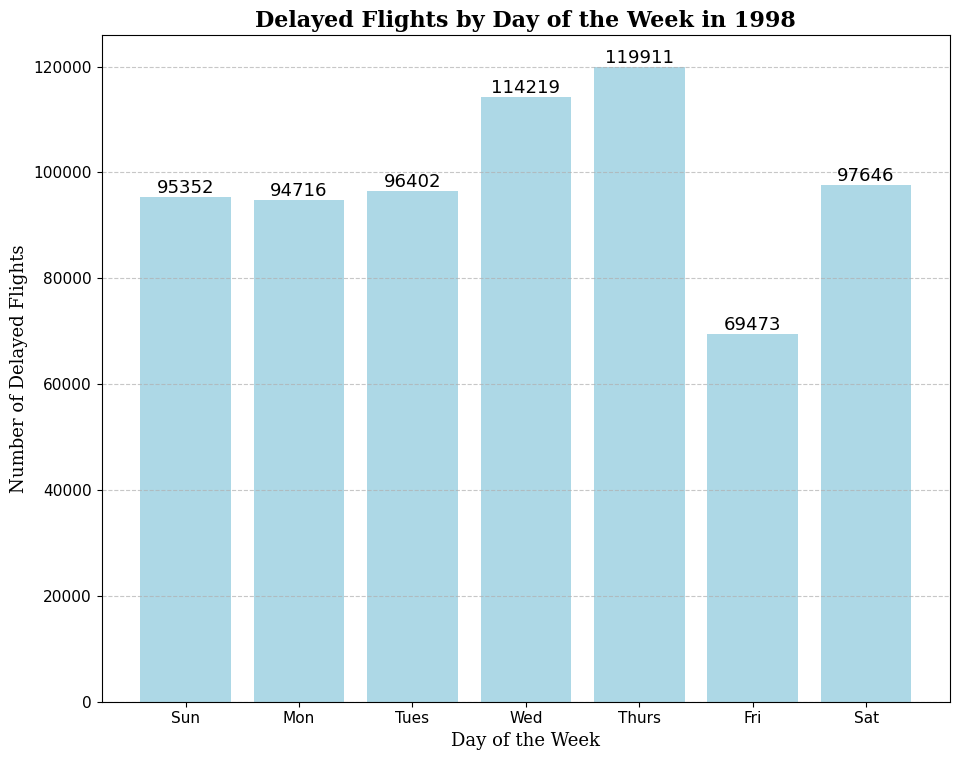

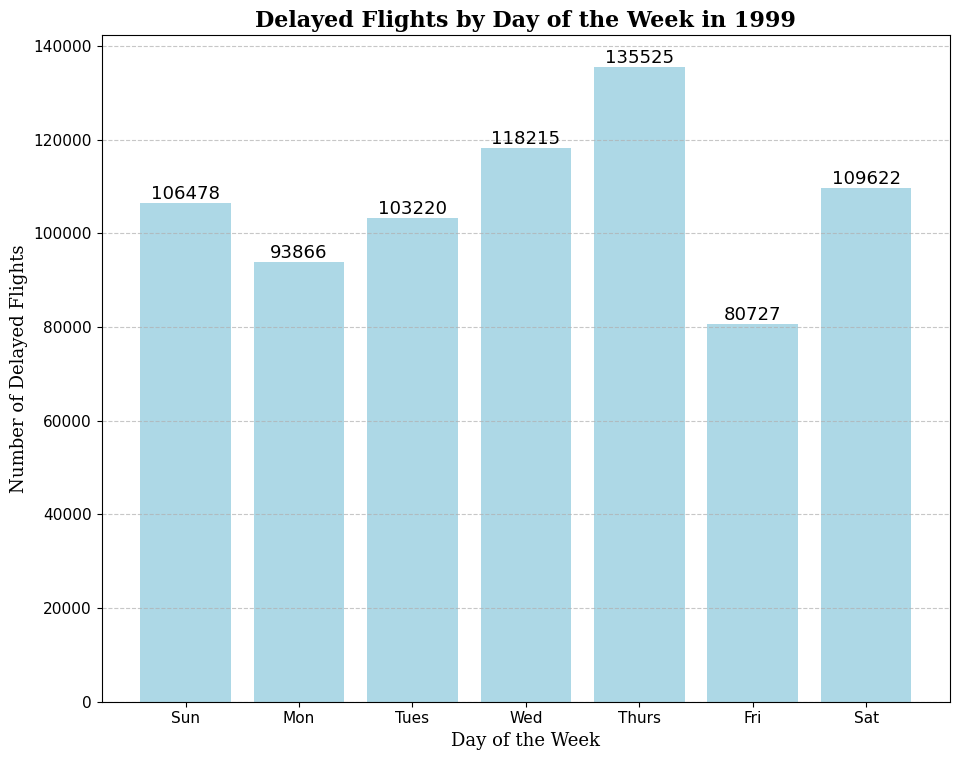

1991: Lowest delayed flights on Fri with 50675 delays.
1992: Lowest delayed flights on Fri with 45075 delays.
1993: Lowest delayed flights on Fri with 48055 delays.
1994: Lowest delayed flights on Fri with 55030 delays.
1995: Lowest delayed flights on Fri with 76768 delays.
1996: Lowest delayed flights on Fri with 88825 delays.
1997: Lowest delayed flights on Mon with 77081 delays.
1998: Lowest delayed flights on Fri with 69473 delays.
1999: Lowest delayed flights on Fri with 80727 delays.


In [134]:
# ======= Answering Q1b best day of the week to fly to minimize delays   =======
# Initialize a dictionary to store the day with the least delays for each year
lowest_delay_day_by_year = {}

for year in range(1991, 2000):
    query = f"""
    SELECT DayOfWeek, COUNT(*) AS Count 
    FROM ontime 
    WHERE Year = {year} AND ArrDelay > 15 AND DepDelay > 15 
    GROUP BY DayOfWeek
    ORDER BY DayOfWeek
    """
    dayOfWeekCounts = pd.read_sql_query(query, conn)
    
    # Initialize counts for all days to 0
    counts = [0]*7  # Assuming DayOfWeek is 1 (Sunday) to 7 (Saturday)
    for _, row in dayOfWeekCounts.iterrows():
        if 1 <= row['DayOfWeek'] <= 7:
            counts[row['DayOfWeek'] - 1] = row['Count']
    
    # Plotting a bar chart for each year
    plt.figure(figsize=(10, 8))
    tick_label = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
    #colors = sns.color_palette("viridis", len(tick_label))
    plt.bar(range(len(counts)), counts, tick_label=tick_label, color='lightblue')
    
    # Adjust the size of the numbers on the axes
    plt.xticks(range(len(tick_label)), tick_label, fontsize=11)  
    plt.yticks(fontsize=11)  
    
    # Add data labels on top of each bar
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=13)

    plt.xlabel('Day of the Week', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.ylabel('Number of Delayed Flights', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.title(f'Delayed Flights by Day of the Week in {year}', fontsize=16, fontweight='bold', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Store the day with the least delays for the year
    min_delay_count = min(counts)
    min_delay_day = tick_label[counts.index(min_delay_count)]
    lowest_delay_day_by_year[year] = {'Day': min_delay_day, 'Count': min_delay_count}

# Output the result for each year's lowest delay day
for year, info in lowest_delay_day_by_year.items():
    print(f"{year}: Lowest delayed flights on {info['Day']} with {info['Count']} delays.")

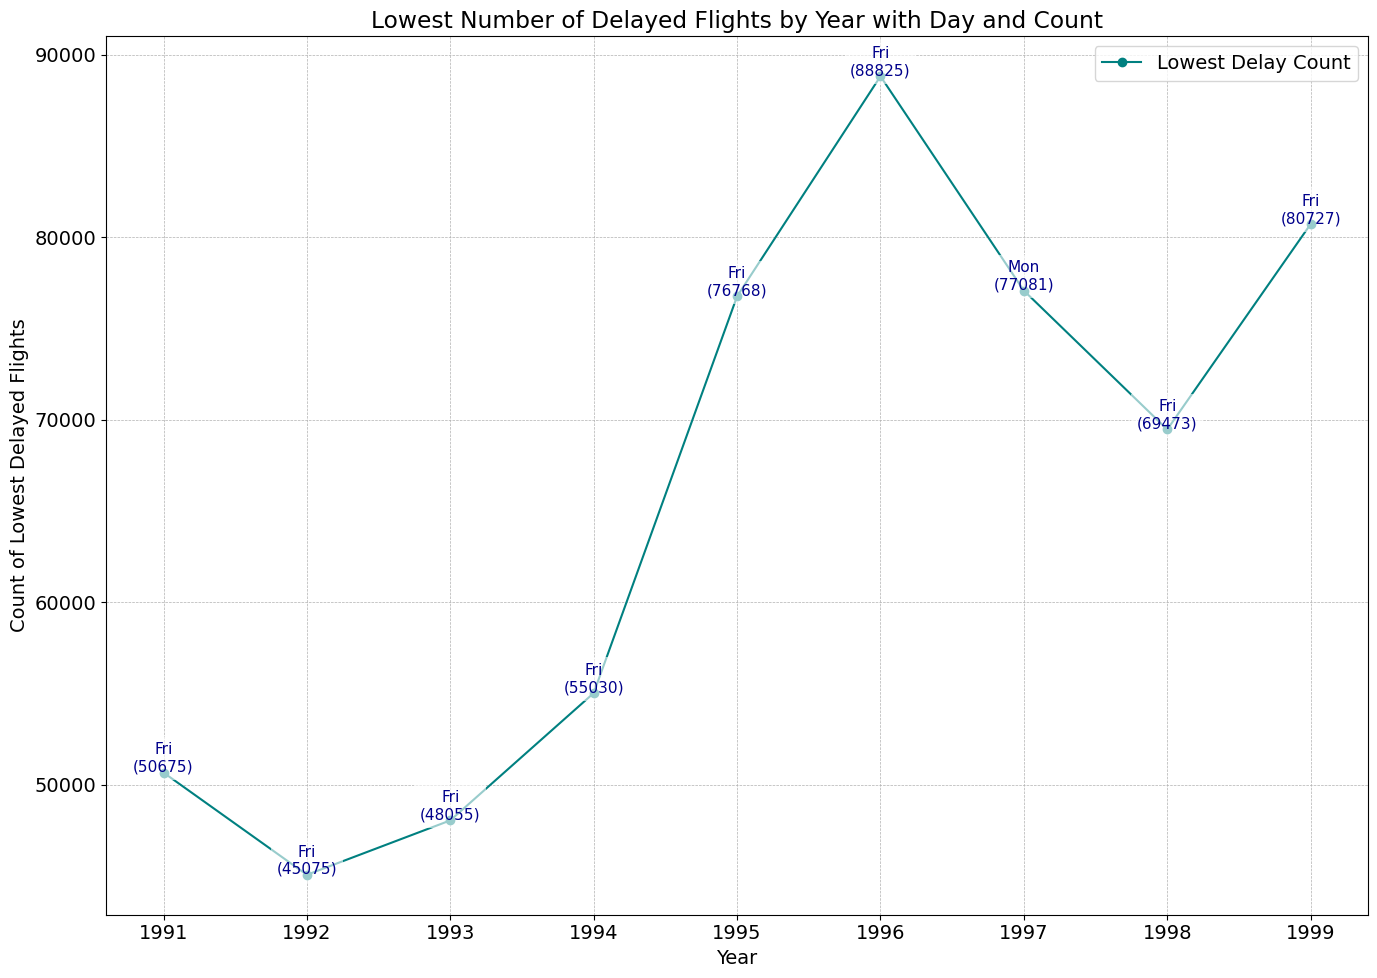

In [147]:

# Assuming lowest_delay_day_by_year is defined as before
years = list(lowest_delay_day_by_year.keys())
lowest_counts = [info['Count'] for info in lowest_delay_day_by_year.values()]
lowest_days = [info['Day'] for info in lowest_delay_day_by_year.values()]

plt.rcParams.update({'font.size': 14})  # Adjusting font size for readability

plt.figure(figsize=(14, 10))
plt.plot(years, lowest_counts, marker='o', linestyle='-', color='teal', label='Lowest Delay Count')

for i, (year, count, day) in enumerate(zip(years, lowest_counts, lowest_days)):
    # Adjusting vertical position for annotation
    vertical_position = count + (max(lowest_counts) - min(lowest_counts)) * 0.001
    # Annotation with both day and count
    annotation_text = f"{day}\n({count})"
    plt.text(year, vertical_position, annotation_text, fontsize=11, ha='center', color='darkblue', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title('Lowest Number of Delayed Flights by Year with Day and Count')
plt.xlabel('Year')
plt.ylabel('Count of Lowest Delayed Flights')
plt.xticks(years)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()


### Answering Q2a) best day of the week to fly to minimize delays OLD ANSWER

In [27]:
# ======= Answering Q1b best day of the week to fly to minimize delays   =======


# ======= getting the day of week for flights that delay less than 5 mins  =======
dayOfWeek= c.execute(''' SELECT DayOfWeek  AS DayOfWeek FROM ontime 
                         WHERE ArrDelay > '15' AND DepDelay >'15' 
    
''').fetchall()

column_name=["DayOfWeek"]
dayOfWeekPd=pd.DataFrame(dayOfWeek, columns= column_name)
print(dayOfWeekPd)


monCount=0  
tuesCount=0
wedCount=0
thursCount=0
friCount=0
satCount=0
sunCount=0
for index, i in dayOfWeekPd.iterrows():  

    if int(i['DayOfWeek']) ==1:
            monCount+=1
    
    elif int(i['DayOfWeek']) ==2:
         tuesCount+=1
    
    elif int(i['DayOfWeek']) ==3:
         wedCount+=1
            
    elif int(i['DayOfWeek']) ==4:
         thursCount+=1
            
    elif int(i['DayOfWeek']) ==5:
         friCount+=1
            
    elif int(i['DayOfWeek']) ==6:
         satCount+=1
            
    else:
         sunCount+=1
    
print(monCount)
print(tuesCount)
print(wedCount)
print(thursCount)
print(friCount)
print(satCount)
print(sunCount)



          DayOfWeek
0                 2
1                 3
2                 4
3                 6
4                 2
...             ...
25861036          3
25861037          4
25861038          5
25861039          6
25861040          7

[25861041 rows x 1 columns]
3934129
3979088
3783559
3532264
3420864
3601183
3609954


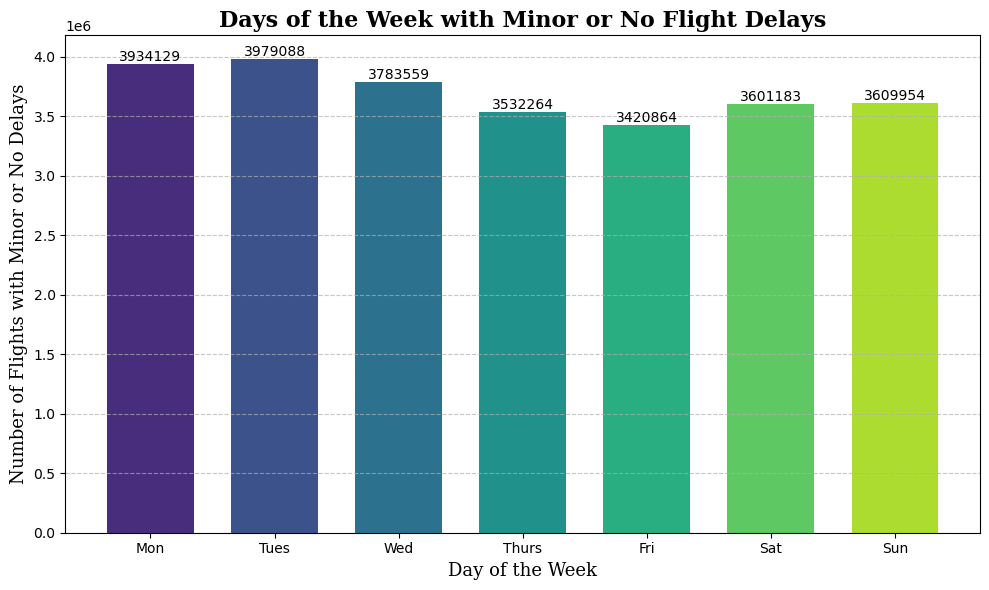

Best day of the week to fly is on a Tuesday


In [182]:
# ======= plotting graph for Q1b  =======

import pandas as pd
from matplotlib import pyplot as plt

  
#x-coordinates of left sides of bars  
left = [0, 1, 2, 3, 4, 5, 6] 
  
# heights of bars 
height = [monCount, tuesCount, wedCount , thursCount, friCount, satCount, sunCount ] 
  

# labels for bars 
tick_label = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'] 

# Set color palette
colors = sns.color_palette("viridis", len(tick_label))


# plotting a bar chart 
plt.figure(figsize=(10, 6))
plt.bar(left, height, tick_label = tick_label, 
        width = 0.7, color = colors) 

# Add data labels on top of each bar
for i, count in enumerate(height):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

# Labels and title
plt.xlabel('Day of the Week', fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Number of Flights with Minor or No Delays',fontdict={'fontsize': 13, 'family': 'serif'})
plt.title('Days of the Week with Minor or No Flight Delays',fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
  
# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show() 

print("Best day of the week to fly is on a Tuesday")






### Answering question 1C, best time of the year to fly to miinimize delays

In [166]:
# ======= Answering Q1c best time of the year to fly to mimimize delays  =======


# ======= getting the year for flights that delay less than 5 mins  =======


timeOfYear= c.execute(''' SELECT Month AS Month FROM ontime 
                         WHERE ArrDelay < '5' AND DepDelay < '5' 
    
''').fetchall()


column_name=["Month"]
timeOfYearPd=pd.DataFrame(timeOfYear, columns= column_name)
print(timeOfYearPd)





janCount=0  
febCount=0
marchCount=0
aprilCount=0
mayCount=0
juneCount= 0
julyCount=0
augCount=0
septCount=0 
octCount=0
novCount=0
decCount=0

for index, i in timeOfYearPd.iterrows():  
    #print(int(i['DepTime']))
    
    if int(i['Month']) == 1:
        
        janCount+=1      
            
    elif int(i['Month']) == 2:   
        febCount+=1
        
    elif int(i['Month']) == 3:   
        marchCount+=1
        
    elif int(i['Month']) == 4:
        aprilCount+=1
       #print(timeOfDayPdMorn)    
    
    elif int(i['Month']) == 5:
        mayCount+=1
        
    elif  int(i['Month']) == 6:
        juneCount+=1
            
    elif  int(i['Month']) == 7:
        julyCount+=1
            
    elif  int(i['Month']) == 8:
        augCount+=1
            
    elif  int(i['Month']) == 9:
        septCount+=1
            
            
    elif  int(i['Month']) == 10:
        octCount+=1
            
    elif  int(i['Month']) == 11:
        novCount+=1
            
    elif  int(i['Month']) == 12:
        decCount+=1
            
            

            


          Month
0             1
1             1
2             1
3             1
4             1
...         ...
25861036     12
25861037     12
25861038     12
25861039     12
25861040     12

[25861041 rows x 1 columns]


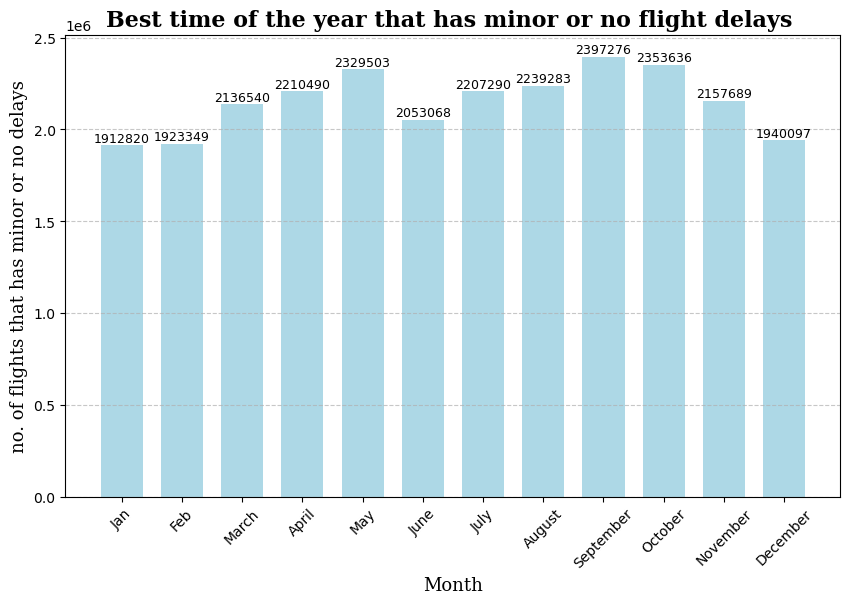

Best time of the year to fly is September 


In [197]:
#Plotting graph for Q1C When is the best time of the year to fly to mimimize delays

import pandas as pd
from matplotlib import pyplot as plt

  
# x-coordinates of left sides of bars  
left = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
  
# heights of bars 
height_months = [janCount, febCount, marchCount , aprilCount, mayCount, juneCount, julyCount,
         augCount, septCount, octCount, novCount, decCount] 
  
    

# labels for bars 
months_label = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October'
             , 'November', 'December'] 


# plotting a bar chart 
plt.figure(figsize=(10, 6))
plt.bar(left, height_months, tick_label = months_label, 
        width = 0.7, color = ['lightblue']) 

# Add data labels on top of each bar
for i, count in enumerate(height_months):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=9)
    
# Labels and title
plt.xlabel('Month', fontdict={'fontsize': 13, 'family': 'serif'}) 
plt.ylabel('no. of flights that has minor or no delays', fontdict={'fontsize': 13, 'family': 'serif'}) 
plt.title('Best time of the year that has minor or no flight delays ', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'}) 


# Rotating the x-axis labels
plt.xticks(rotation=45, fontsize= 10)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.show() 

print("Best time of the year to fly is September ")


### Answering question do older planes suffer more delays 

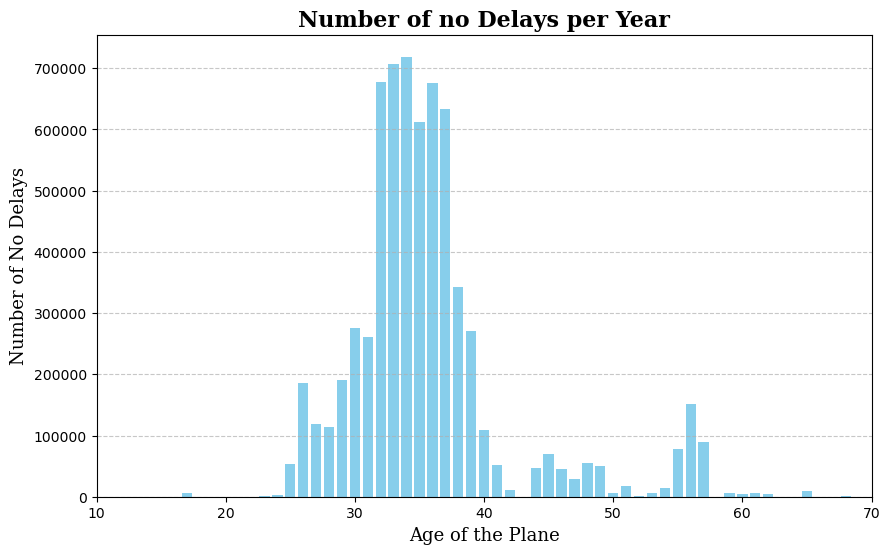

In [5]:
#Old code 
from matplotlib import pyplot as plt
# Fetch data from the database
dateOfPlane = c.execute('''
    SELECT CAST(planeData.year AS INTEGER) AS year
    FROM planeData
    JOIN ontime ON planeData.TailNum = ontime.TailNum
    WHERE CAST(ontime.ArrDelay AS INTEGER) < 15 AND CAST(ontime.DepDelay AS INTEGER) < 15
    AND planeData.year IS NOT NULL
''').fetchall()

# Create a DataFrame
column_name = ["Year"]
datesOfPlaneDp = pd.DataFrame(dateOfPlane, columns=column_name)

# Convert 'Year' column to integers and subtract from 2024
datesOfPlaneDp['Year'] = datesOfPlaneDp['Year'].apply(lambda x: 2024 - int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)

# Group by year and count the occurrences
delay_counts = datesOfPlaneDp['Year'].value_counts().sort_index()

# Plot the graph
plt.figure(figsize=(10, 6))
bars=plt.bar(delay_counts.index, delay_counts.values, color='skyblue')


    
# Labels and title
plt.title('Number of no Delays per Year', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
plt.xlabel('Age of the Plane',  fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Number of No Delays',  fontdict={'fontsize': 13, 'family': 'serif'})

#Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.xlim(10, 70) 


plt.show()



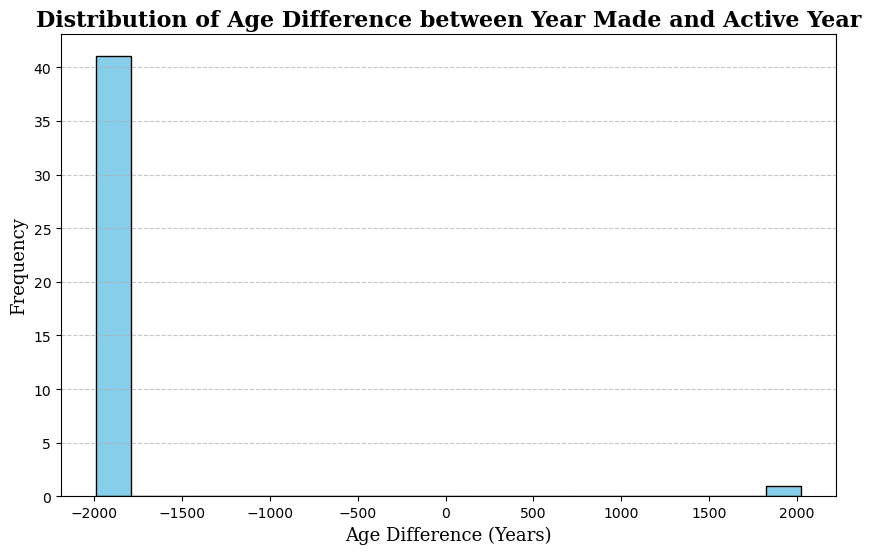

In [23]:

from matplotlib import pyplot as plt
# Fetch the year of the plane
quaery = c.execute('''
    SELECT CAST(planeData.year AS INTEGER) AS yearMade, CAST(ontime.year AS INTEGER) AS activeYearOfPlane
    FROM planeData
    JOIN ontime ON planeData.TailNum = ontime.TailNum
    WHERE CAST(ontime.ArrDelay AS INTEGER) < 15 AND CAST(ontime.DepDelay AS INTEGER) < 15
    AND planeData.year IS NOT NULL
''').fetchall()

data = c.execute(query).fetchall()


# Calculate the age difference between the year a plane was made and the year it was active
age_difference = [row[1] - row[0] for row in data]

# Plot histogram of age difference
plt.figure(figsize=(10, 6))
plt.hist(age_difference, bins=20, color='skyblue', edgecolor='black')

# Labels and title
plt.title('Distribution of Age Difference between Year Made and Active Year', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
plt.xlabel('Age Difference (Years)', fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Frequency', fontdict={'fontsize': 13, 'family': 'serif'})

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

            

### Answering Q2c) Logistic regression


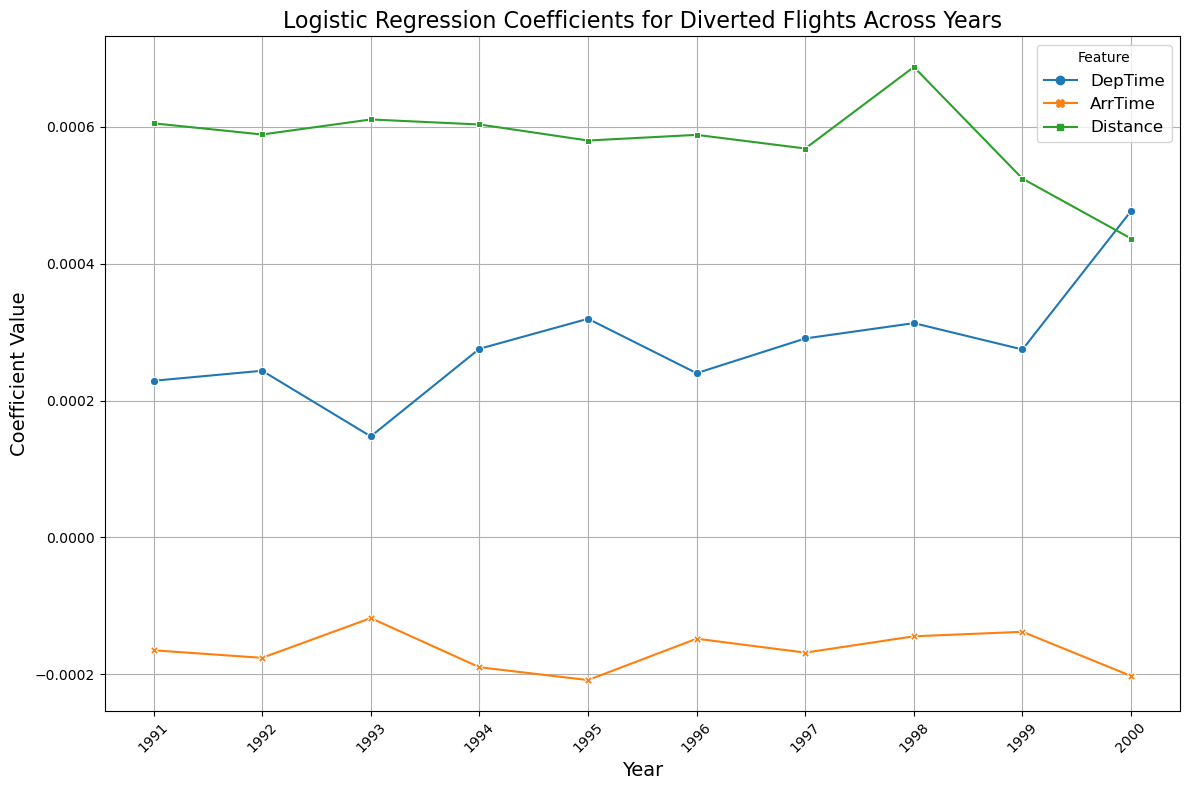

In [27]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the airport data
airportData = pd.read_csv('/Users/christopherpang/Desktop/Main/SIM uni year 2/Programming for data science/Coursework_data/dataverse_files/plane-data.csv')
# Define your features and target variable for the logistic regression model
features = ['DepTime', 'ArrTime', 'Distance']  # Adjust features as necessary
target = 'Diverted'

# Initialize an empty DataFrame to store coefficients for each year
coefficients_df = pd.DataFrame()

for year in range(1991, 2001):
    # Subset the data for the current year
    year_data = ontime_df[ontime_df['Year'] == year].copy()
    
    # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    year_data[features] = imputer.fit_transform(year_data[features])

    # Splitting the data into features (X) and target (y)
    X = year_data[features]
    y = year_data[target]

    # Splitting dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing and fitting the logistic regression model
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(X_train, y_train)

    # Getting coefficients and intercept
    coefficients = np.insert(logistic_model.coef_[0], 0, logistic_model.intercept_[0])  # Adding intercept

    # Creating a temporary DataFrame to hold coefficients for the current year
    temp_df = pd.DataFrame([coefficients], columns=['Intercept'] + features)
    temp_df['Year'] = year

    # Adding the temporary DataFrame to the main coefficients DataFrame
    if coefficients_df.empty:
        coefficients_df = temp_df
    else:
        coefficients_df = pd.concat([coefficients_df, temp_df], ignore_index=True)

# Setting 'Year' as the DataFrame index for plotting
coefficients_df.set_index('Year', inplace=True)

# Plotting the coefficients for each feature across years
plt.figure(figsize=(12, 8))
sns.lineplot(data=coefficients_df.drop(columns='Intercept').astype(float), markers=True, dashes=False)
plt.title('Logistic Regression Coefficients for Diverted Flights Across Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.xticks(np.arange(1991, 2001), rotation=45)
plt.legend(title='Feature', loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

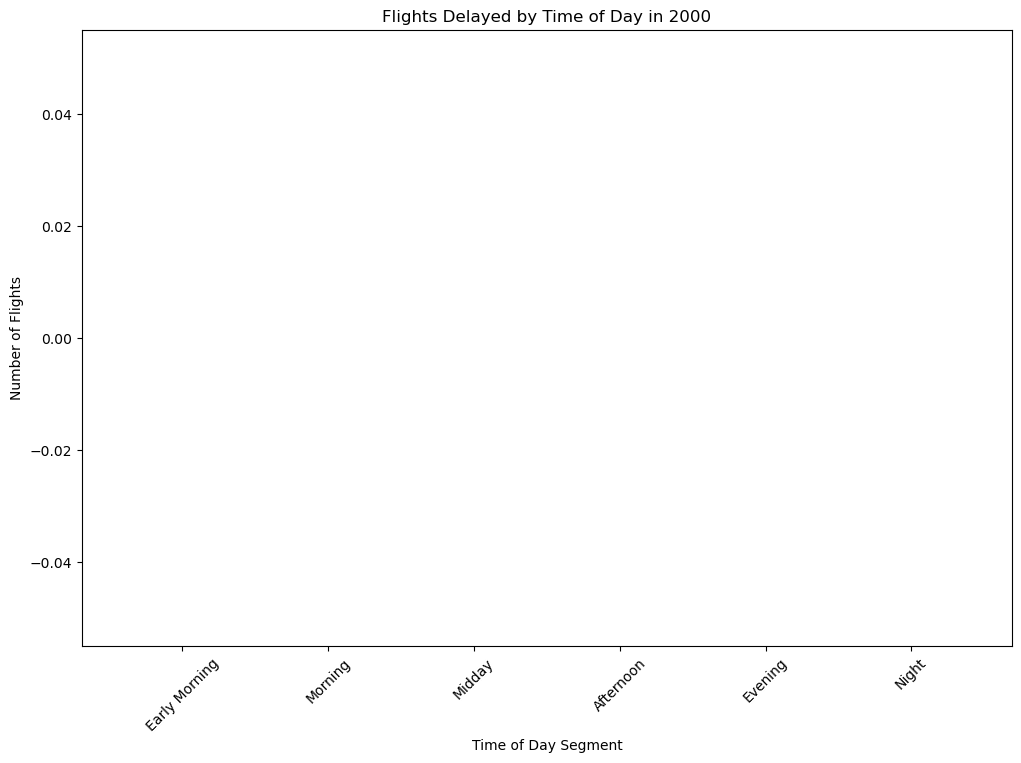

Empty DataFrame
Columns: [DepTime, Segment]
Index: []
Early Morning    0
Morning          0
Midday           0
Afternoon        0
Evening          0
Night            0
Name: Segment, dtype: int64


In [59]:
year = 2000

# SQL query to fetch the required data
query = f"""
SELECT CAST(DepTime AS INTEGER) AS DepTime FROM ontime
WHERE ArrDelay > 15 AND DepDelay > 15 AND Year = {year}
"""

# Execute query and load data into a DataFrame
timeOfDayPd = pd.read_sql_query(query, conn)

# Ensure DepTime is in the correct four-digit format and categorize into segments
timeOfDayPd['DepTime'] = timeOfDayPd['DepTime'].apply(lambda x: f"{x:04d}")
timeOfDayPd['Segment'] = timeOfDayPd['DepTime'].apply(time_segment)

# Order segments and count occurrences
segment_order = ['Early Morning', 'Morning', 'Midday', 'Afternoon', 'Evening', 'Night']
timeOfDayPd['Segment'] = pd.Categorical(timeOfDayPd['Segment'], categories=segment_order, ordered=True)
segment_counts_ordered = timeOfDayPd.groupby('Segment').size()

# Basic plot to ensure it renders without layout issues
plt.figure(figsize=(12, 8))
plt.bar(segment_counts_ordered.index, segment_counts_ordered.values, color='teal')

# Basic titles and labels without additional adjustments
plt.title(f'Flights Delayed by Time of Day in {year}')
plt.xlabel('Time of Day Segment')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)

plt.show()
print(timeOfDayPd.head())  # Check the first few rows to ensure data is loaded

# After categorizing into segments
print(timeOfDayPd['Segment'].value_counts()) 